In [1]:
import numpy as np
from obj2html import obj2html
from IPython.display import display, HTML
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch import nn
import torch
import wandb

from metrics import calc_symmetric_f1, sample_points_bb, sample_points_ns
from siren import sdf, PointCloud, Siren
from ddd import process_obj, read_obj

In [2]:
obj_path = 'test_task_meshes/0.obj'
obj2html(obj_path, 'index.html')
display(HTML('index.html'))

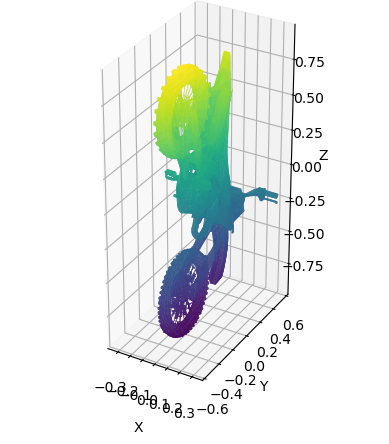

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_mesh(vertices, faces):
    """Plot vertices and faces using matplotlib trisurf"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set equal aspect ratio for all axes
    ax.set_box_aspect([np.ptp(coord) for coord in [vertices[:, 0], vertices[:, 1], vertices[:, 2]]])

    # plt.show()

# Example usage
vertices, faces = read_obj(obj_path)
plot_mesh(vertices, faces)

# Meshplot lib
# mp.plot(vertices, faces);

Sampling and F1 functions

In [10]:
def eval_step(model, train_dataloader, obj_path):
    model.eval()
    metrics = {}
    with torch.no_grad():
        coord_max = train_dataloader.dataset.coord_max
        coord_min = train_dataloader.dataset.coord_min
        centroid = train_dataloader.dataset.centroid

        for metric_name, sample_fn in [('bounding F1', sample_points_bb), ('surface F1', sample_points_ns)]:
            points, are_inside = sample_points_ns(obj_path, 10_000)
            points -= centroid
            points = (points - coord_min) / (coord_max - coord_min)
            points -= 0.5
            points *= 2.0
            points = torch.tensor(points, device='cuda', dtype=torch.float32)
            pred_dist = model({'coords': points})['model_out']
            
            f1 = calc_symmetric_f1(pred_dist[:, 0] < 0, torch.tensor(are_inside, dtype=torch.bool, device='cuda'))
            metrics[metric_name] = f1
    return metrics


def train_siren(model, train_dataloader, epochs, lr, loss_fn, obj_path, weights_path, clip_grad=False):
    min_train_loss = float('inf')

    optim = torch.optim.Adam(lr=lr, params=model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.1, patience=4)
    
    wandb.init(project='siren-sdf', entity='bogdanmagometa')

    total_steps = 0
    for epoch in range(epochs):
        model.train()

        for step, (model_input, gt) in enumerate(train_dataloader):
            model_input = {key: value.cuda() for key, value in model_input.items()}
            gt = {key: value.cuda() for key, value in gt.items()}

            model_output = model(model_input)
            losses = loss_fn(model_output, gt)
            reduced_losses = {loss_name: torch.mean(loss) for loss_name, loss in losses.items()}
            train_loss = sum(torch.mean(loss) for loss in losses.values())

            wandb.log(reduced_losses, commit=False)
            wandb.log({'total_train_loss': train_loss, 'global_step': total_steps})

            optim.zero_grad()
            train_loss.backward()

            if clip_grad:
                if isinstance(clip_grad, bool):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

            optim.step()

            total_steps += 1

        if (epoch % 10) == 0:
            print(f"Train loss = {train_loss:.2f}")
            metrics = eval_step(model, train_dataloader, obj_path)
            for name, val in metrics.items():
                print(f"{name} = {val:.2f}")
            wandb.log({**metrics, 'epoch': epoch})
            if train_loss < min_train_loss:
                min_train_loss = train_loss
                torch.save(
                    {
                        'centroid': dataloader.dataset.centroid,
                        'coord_min': dataloader.dataset.coord_min,
                        'coord_max': dataloader.dataset.coord_max,
                        'weights': model.state_dict()
                    },
                    weights_path)
            scheduler.step(train_loss)

process_obj('./test_task_meshes/0.obj', '0.xyz', num_samples=100_000)

sdf_dataset = PointCloud('./0.xyz', on_surface_points=5000)
dataloader = DataLoader(sdf_dataset, batch_size=None, shuffle=True, pin_memory=True, num_workers=0)

model = Siren(3, 256, 3, 1)
model.cuda()

weights_path = './0.pt'

train_siren(model, dataloader, epochs=50, lr=1e-4, loss_fn=sdf, obj_path='./test_task_meshes/0.obj', weights_path=weights_path, clip_grad=False)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


bounding F1,▁▇▇██
epoch,▁▃▅▆█
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
grad_constraint,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
inter,█▃▂▃▂▂▂▂▃▂▂▁▂▂▂▂▁▂▂▁▂▂▂▂▂▁▂▂▂▂▂▁▁▂▂▂▂▁▂▂
normal_constraint,█▆▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
sdf,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
surface F1,▁▇███
total_train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bounding F1,0.81755
epoch,40


Train loss = 62.31
bounding F1 = 0.66
surface F1 = 0.66
Train loss = 30.27
bounding F1 = 0.80
surface F1 = 0.80
Train loss = 26.47
bounding F1 = 0.79
surface F1 = 0.78
Train loss = 23.75
bounding F1 = 0.82
surface F1 = 0.83


In [6]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


bounding F1,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
grad_constraint,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
inter,▇▆▁▆▄▄▃▃▅▄▄▃▄▁▅▄▁▂▅▄▃▄▅█▄▄▃▆▅▂▃▅▆▇▆▄▅▆▅▆
normal_constraint,█▆▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁
sdf,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
surface F1,▁▆▇▇▇▇▇█▇█
total_train_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bounding F1,0.84469
epoch,90


Measure inference time

In [123]:
device = 'cuda'

points_3k, _ = sample_points_bb('./test_task_meshes/0.obj', 50_000)
points_3k = torch.tensor(points_3k).float().to(device)
single_point, _ = sample_points_bb('./test_task_meshes/0.obj', 1)
single_point = torch.tensor(single_point).float().to(device)

model.eval()
model.to(device);


In [124]:
import gc; gc.collect()

0

In [125]:
%%time
with torch.no_grad():
    signed_dist = model({'coords': points_3k})['model_out']
    torch.cuda.synchronize()

CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 2.96 ms


In [102]:
%%timeit
with torch.no_grad():
    signed_dist = model({'coords': single_point})['model_out']
    torch.cuda.synchronize()

337 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
